# **Segmentation des clients d'un site e-commerce**
___
Olist (un site d'e-commerce au Brésil) souhaite obtenir une segmentation de ses clients utilisable au quotidien par leur équipe marketing dans leurs campagnes de communication.

L'objectif est de comprendre les différents types d'utilisateurs grâce à leur comportement et à leurs **données personnelles anonymisées**.

Nous allons donc fournir ici une description actionable de la segmentation et de sa logique sous-jacente pour une utilisation optimale. Nous devrons également fournir une analyse de la stabilité des segments au cours du temps *(dans le but d'établir un contrat de maintenance)*.

Nous utilisererons donc des **méthodes non supervisées** pour regrouper ensemble des clients de profils similaires.
___

Cette étude est organisée en 2 notebooks: 
- Notebook de nettoyage, feature engineering et analyse exploratoire
- Notebook de modélisation et segmentation

___
## Notebook 2 : Modélisations et segmentation


## 0. MISE EN PLACE

 Nous commençons par mettre en place notre cadre de travail en effectuant les actions suivantes :
 - Importation des librairies et packages Python nécessaires
 - Importation des fonctions utiles implémentées 
 - Chargement du jeu de données

___
### 0.1 Importation des librairies Python nécessaires

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import (preprocessing,
                     manifold,
                     decomposition)
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.metrics import pairwise_distances_argmin_min
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
import seaborn as sns
import scipy.cluster.hierarchy as shc

___
### 0.2 Importation des fonctions utiles

Par soucis de clarté (lisibilité) et afin d'assurer un meilleur confort de lecture de ce notebook, les fonctions implémentées pour la manipulation des données et la réalisation des graphiques ont été regroupées dans le fichier project_functions.py.

Ces fonctions sont importées via la ligne de code ci-dessous:

In [3]:
import project_functions as pf

___
### 0.3 Chargement du jeu de données

In [4]:
customer_data = pd.read_csv("./customer_data-cleaned.csv",index_col=0)

In [5]:
customer_data.head(3)

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      1.0   
0000f46a3911fa3c0805444483337064                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
0000f46a3911fa3c0805444483337064                        8.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                5.0                 6.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                 3.0   
0000f46a3911fa3c0805444483337064                3.0                26.0   

                                  favorite_sale_month  books_cds_media  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2                    5              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    5              0.0   
0000f46a3911fa3c0805444483337064                    3              0.0   

                                  fashion_clothing_accessories  flowers_gifts  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                           0.0            0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                           0.0            0.0   
0000f46a3911fa3c0805444483337064                           0.0            0.0   

                                  ...  total_items  mean_nb_items  \
customer_unique_id                ...                               
0000366f3b9a7992bf8c76cfdf3221e2  ...          1.0            1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...          1.0            1.0   
0000f46a3911fa3c0805444483337064  ...          1.0            1.0   

                                  order_mean_delay  freight_ratio  \
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2             111.0           0.08   
0000b849f77a49e4a4ce2b2a4ca5be3f             114.0           0.30   
0000f46a3911fa3c0805444483337064             537.0           0.20   

                                  mean_price_order  customer_zip_code_prefix  \
customer_unique_id                                                             
0000366f3b9a7992bf8c76cfdf3221e2             129.9                      7787   
0000b849f77a49e4a4ce2b2a4ca5be3f              18.9                      6053   
0000f46a3911fa3c0805444483337064              69.0                     88115   

                                  customer_city  customer_state  \
customer_unique_id                                                
0000366f3b9a7992bf8c76cfdf3221e2        cajamar       São Paulo   
0000b849f77a49e4a4ce2b2a4ca5be3f         osasco       São Paulo   
0000f46a3911fa3c0805444483337064       sao jose  Santa Catarina   

                                   Flag and name  harvesine_distance  
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2       São Paulo          209.713834  
0000b849f77a49e4a4ce2b2a4ca5be3f       São Paulo          209.713834  
0000f46a3911fa3c0805444483337064  Santa Catarina          125.363853  

[3 rows x 27 columns]

## 1. SELECTION DES FEATURES

Nous allons commencer par sélectionner les features que nous allons garder pour les essaies de modélisation. 

Nous allons supprimer `customer_zip_code_prefix` et `customer_city`, `customer_state` pour ne conserver que la variable `haversine_distance` pour indiquer une localisation "large" des clients, ce qui évitera de focaliser la segmentation sur la localisation du client.

Nous allons également supprimer `mean_price_order` et `mean_nb_items` puisque nous avons vu lors de l'analyse exploratoire que ces variables sont fortement corrélées aux totaux pour le moment.

In [6]:
data = customer_data.drop(columns=["customer_zip_code_prefix",
                                   "customer_city",
                                   "customer_state",
                                   "Flag and name",
                                   "mean_price_order",
                                   "mean_nb_items"])

## 2. PREPROCESSING

Nous allons séparer les données numériques et les données catégorielles de notre dataset :

In [7]:
numerical_features = data.select_dtypes(include=['int64','float64', 'uint8'])
categorical_features = data.select_dtypes(exclude=['int64', 'float64', 'uint8'])

In [8]:
list(categorical_features.columns)

[]

In [9]:
list(numerical_features.columns)

['nb_orders',
 'total_spend',
 'mean_payment_sequential',
 'mean_payment_installments',
 'mean_review_score',
 'mean_delivery_days',
 'favorite_sale_month',
 'books_cds_media',
 'fashion_clothing_accessories',
 'flowers_gifts',
 'groceries_food_drink',
 'health_beauty',
 'home_furniture',
 'other',
 'sport',
 'technology',
 'toys_baby',
 'total_items',
 'order_mean_delay',
 'freight_ratio',
 'harvesine_distance']

### Normalisation des variables numériques (avec MinMaxScaler)

In [10]:
numerical_features_columns = numerical_features.columns 
# MinMax scaled

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data[numerical_features_columns])
data_scaled = pd.DataFrame(data_scaled,index=data.index,columns=numerical_features_columns)

data_scaled.head(3)

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2        0.0     0.009690   
0000b849f77a49e4a4ce2b2a4ca5be3f        0.0     0.001289   
0000f46a3911fa3c0805444483337064        0.0     0.005612   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      0.0   
0000f46a3911fa3c0805444483337064                      0.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                   0.307692   
0000b849f77a49e4a4ce2b2a4ca5be3f                   0.038462   
0000f46a3911fa3c0805444483337064                   0.307692   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2               1.00            0.024155   
0000b849f77a49e4a4ce2b2a4ca5be3f               0.75            0.009662   
0000f46a3911fa3c0805444483337064               0.50            0.120773   

                                  favorite_sale_month  books_cds_media  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2             0.363636              0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f             0.363636              0.0   
0000f46a3911fa3c0805444483337064             0.181818              0.0   

                                  fashion_clothing_accessories  flowers_gifts  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                           0.0            0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                           0.0            0.0   
0000f46a3911fa3c0805444483337064                           0.0            0.0   

                                  ...  health_beauty  home_furniture  other  \
customer_unique_id                ...                                         
0000366f3b9a7992bf8c76cfdf3221e2  ...            0.0             1.0    0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f  ...            1.0             0.0    0.0   
0000f46a3911fa3c0805444483337064  ...            0.0             0.0    1.0   

                                  sport  technology  toys_baby  total_items  \
customer_unique_id                                                            
0000366f3b9a7992bf8c76cfdf3221e2    0.0         0.0        0.0          0.0   
0000b849f77a49e4a4ce2b2a4ca5be3f    0.0         0.0        0.0          0.0   
0000f46a3911fa3c0805444483337064    0.0         0.0        0.0          0.0   

                                  order_mean_delay  freight_ratio  \
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2          0.155680       0.083333   
0000b849f77a49e4a4ce2b2a4ca5be3f          0.159888       0.312500   
0000f46a3911fa3c0805444483337064          0.753156       0.208333   

                                  harvesine_distance  
customer_unique_id                                    
0000366f3b9a7992bf8c76cfdf3221e2            0.051121  
0000b849f77a49e4a4ce2b2a4ca5be3f            0.051121  
0000f46a3911fa3c0805444483337064            0.008493  

[3 rows x 21 columns]

## 2. RÉDUCTION DIMENSIONNELLE

Nous allons utiliser une ACP pour réduire la dimension de nos données 

In [11]:
#dimension des données avant réduction

data_scaled.shape

(92755, 21)

### 2.1 PCA

**Choix du nombre de composantes**

In [12]:
N_COMPONENTS = 11

In [13]:
pca = decomposition.PCA(n_components=N_COMPONENTS)
pca_results = pca.fit_transform(data_scaled)

In [14]:
print('Explained variation per principal component: {}'\
      .format(pca.explained_variance_ratio_))

print('Cumulative explained variation for {} principal components: {}'\
      .format(N_COMPONENTS, np.sum(pca.explained_variance_ratio_)))

Explained variation per principal component: [0.21583082 0.12815858 0.11220061 0.09222644 0.09086777 0.07585948
 0.07304876 0.06186576 0.04164794 0.03270006 0.03238523]
Cumulative explained variation for 11 principal components: 0.9567914589338394


**Éboulis des valeurs propres**

Ce diagramme décrit le pourcentage d’inertie totale associé à chaque axe

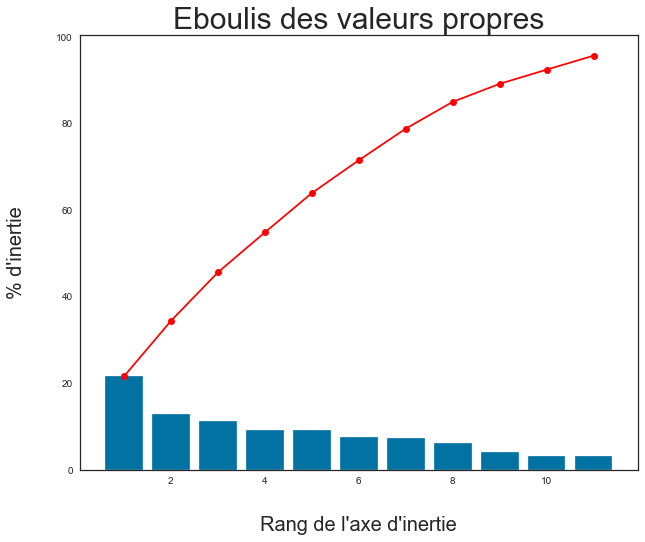

In [15]:
sns.set_style("white")
pf.display_scree_plot(pca)

11 composantes expliquent 95% de la variance observées dans les données

In [16]:
columns = ['pca_comp_%i' % i for i in range(N_COMPONENTS)]
df_pca = pd.DataFrame(pca_results, columns=columns, index=data.index)
df_pca.shape

(92755, 11)

### 2.2 Visualisation PCA(2D) et T-SNE(2D)

Nous pouvons visualiser nos données sur des graphiques en observant les projections des données sur les 2 composantes de la PCA et sur 2 dimensions de T-SNE 

In [17]:
time_start = time.time()

tsne = manifold.TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(data_scaled)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 92755 samples in 0.003s...
[t-SNE] Computed neighbors for 92755 samples in 247.368s...
[t-SNE] Computed conditional probabilities for sample 1000 / 92755
[t-SNE] Computed conditional probabilities for sample 2000 / 92755
[t-SNE] Computed conditional probabilities for sample 3000 / 92755
[t-SNE] Computed conditional probabilities for sample 4000 / 92755
[t-SNE] Computed conditional probabilities for sample 5000 / 92755
[t-SNE] Computed conditional probabilities for sample 6000 / 92755
[t-SNE] Computed conditional probabilities for sample 7000 / 92755
[t-SNE] Computed conditional probabilities for sample 8000 / 92755
[t-SNE] Computed conditional probabilities for sample 9000 / 92755
[t-SNE] Computed conditional probabilities for sample 10000 / 92755
[t-SNE] Computed conditional probabilities for sample 11000 / 92755
[t-SNE] Computed conditional probabilities for sample 12000 / 92755
[t-SNE] Computed conditional probabilities for 

Text(0, 0.5, 't-SNE 2')

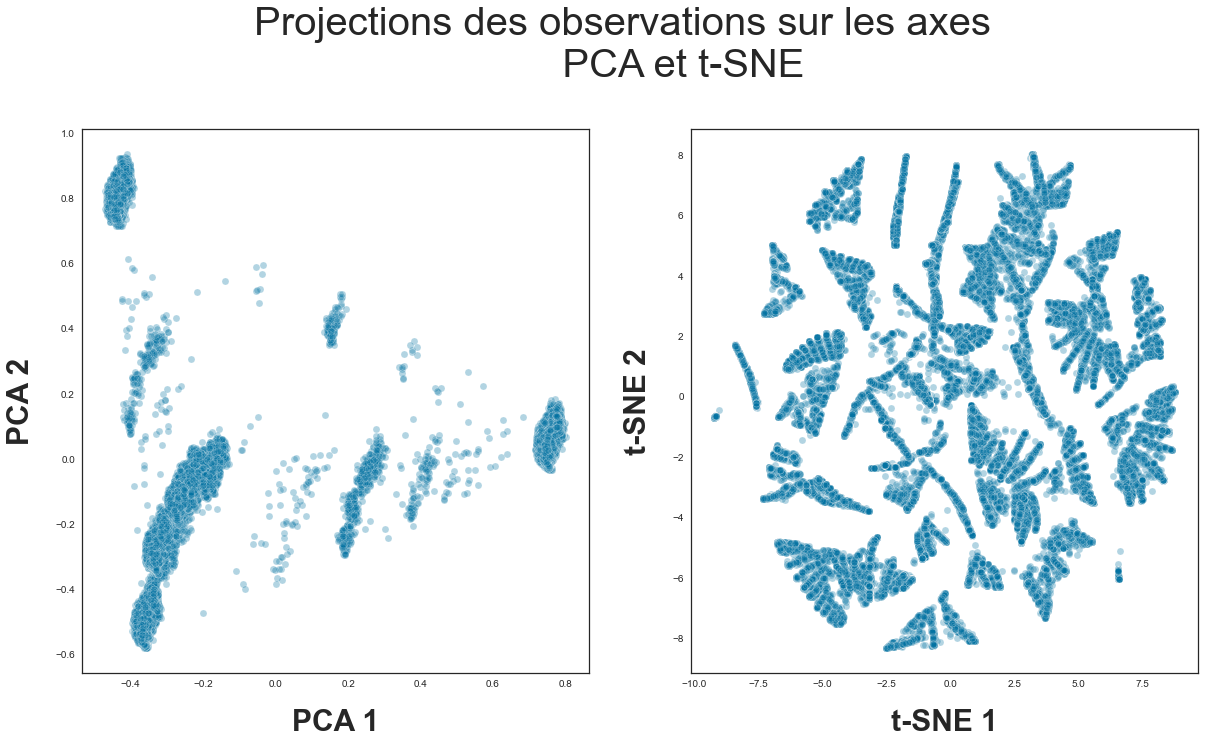

In [18]:
data_to_plot = pd.DataFrame()
data_to_plot["pca-one"] = pca_results[:,0]
data_to_plot["pca-two"] = pca_results[:,1]
data_to_plot["tsne-2d-one"] = tsne_results[:,0]
data_to_plot["tsne-2d-two"] = tsne_results[:,1]


TITLE_SIZE = 40
TITLE_PAD = 1.05
LABEL_SIZE = 30
LABEL_PAD = 20

f, (ax1, ax2) = plt.subplots(ncols=2,
                             sharey=False,
                             figsize=(20, 10))

f.suptitle("Projections des observations sur les axes\n\
           PCA et t-SNE", fontsize=TITLE_SIZE, y=TITLE_PAD)

ax1 = plt.subplot(1, 2, 1)

handle_plot_1 = sns.scatterplot(x="pca-one", y="pca-two",
                                data=data_to_plot,
                                legend="full",
                                alpha=0.3,
                                ax=ax1)

handle_plot_1.set_xlabel("PCA 1",
                         fontsize=LABEL_SIZE,
                         labelpad=LABEL_PAD,
                         fontweight="bold")

handle_plot_1.set_ylabel("PCA 2",
                         fontsize=LABEL_SIZE,
                         labelpad=LABEL_PAD,
                         fontweight="bold")


ax2 = plt.subplot(1, 2, 2)
handle_plot_2 = sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                                data=data_to_plot,
                                legend="full",
                                alpha=0.3,
                                ax=ax2)

handle_plot_2.set_xlabel("t-SNE 1",
                         fontsize=LABEL_SIZE,
                         labelpad=LABEL_PAD,
                         fontweight="bold")

handle_plot_2.set_ylabel("t-SNE 2",
                         fontsize=LABEL_SIZE,
                         labelpad=LABEL_PAD,
                         fontweight="bold")

## 3. CHOIX DU MODEL (Test de plusieurs algorithmes de clustering) 

Nous allons maintenant tester différent type d'algorithme de clustering sur nos données réduites (les composantes de la PCA) afin de choisir le modèle le plus adapté. 

**Algorithmes testés**

- KMeans
- DBSCAN
- Clustering hiérarchique 

**Critères de comparaison des algorithmes testés**

- Forme des clusters
    * resserrés sur eux-mêmes (homogénéité)
    * loin les uns des autres (séparation) 
> Coefficient de silhouette compris en [-1;1] => pour evaluer un clustering, on peut calculer le coefficient de silhouette moyen.

- Compatibilité avec des connaissances spécifiques au domaine

### 3.1 K-Means

#### 3.1.1 Choix du nombre de clusters 

##### 3.1.1.1 Méthode du coude

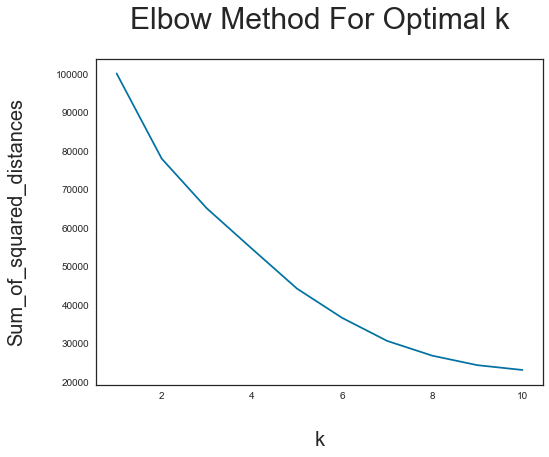

In [19]:
pf.plotEblow(df_pca, 8, 6)

**La méthode du coude suggère que le nombre de clusters optimal autour de 7**

##### 3.1.1.2 Silhouette Visualizer

Pour vérifier si le K choisi par la méthode du coude se confirme, nous allons utiliser `SilhouetteVisualizer` avec des plusieurs valeurs de K. Cela permet de visualiser la densité et la séparation des clusters. 

For n_clusters = 2 The average silhouette_score is : 0.23617980950086856
For n_clusters = 3 The average silhouette_score is : 0.31345387509819717
For n_clusters = 4 The average silhouette_score is : 0.38041724748655165
For n_clusters = 5 The average silhouette_score is : 0.4389089911564369
For n_clusters = 6 The average silhouette_score is : 0.4820523965030342
For n_clusters = 7 The average silhouette_score is : 0.5133391445452984
For n_clusters = 8 The average silhouette_score is : 0.513265343174974
For n_clusters = 9 The average silhouette_score is : 0.4648693877917464
For n_clusters = 10 The average silhouette_score is : 0.44455697783243786


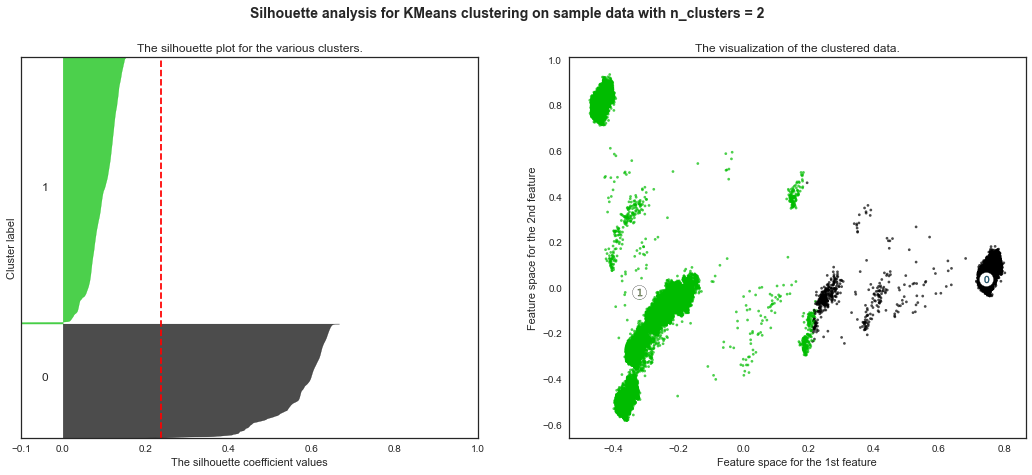

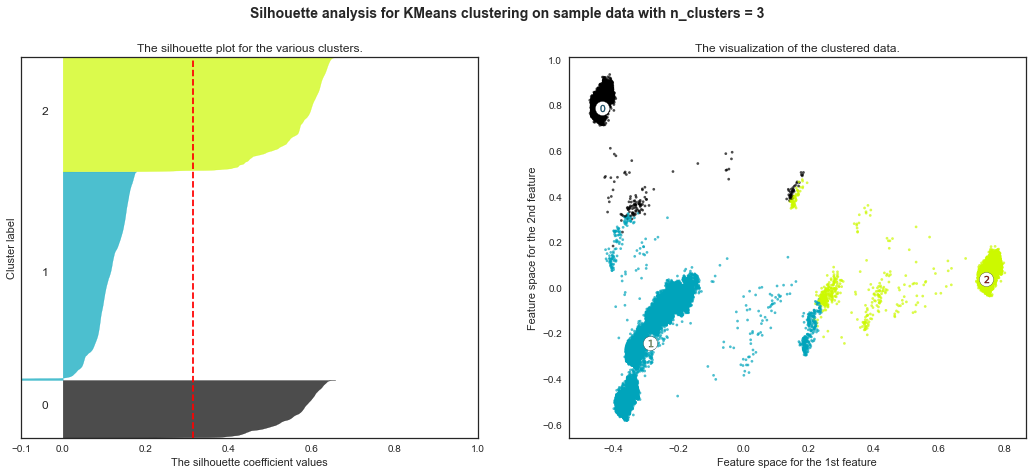

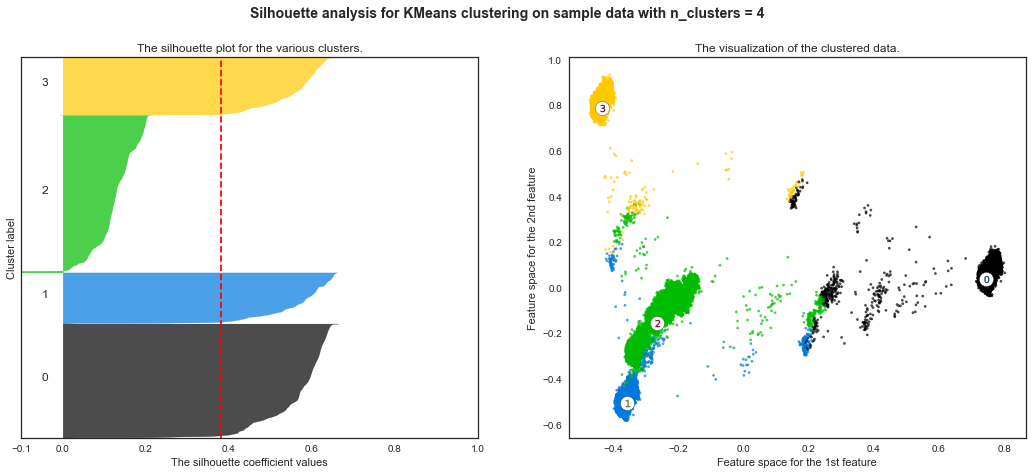

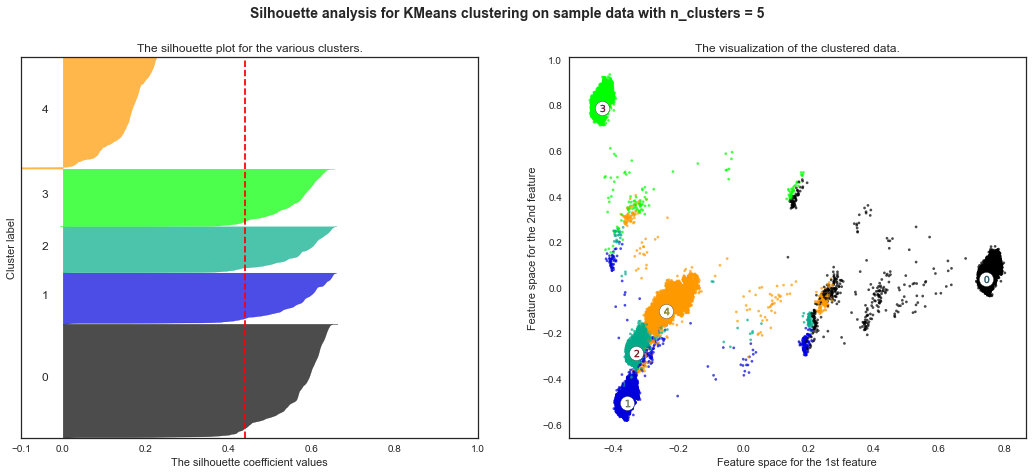

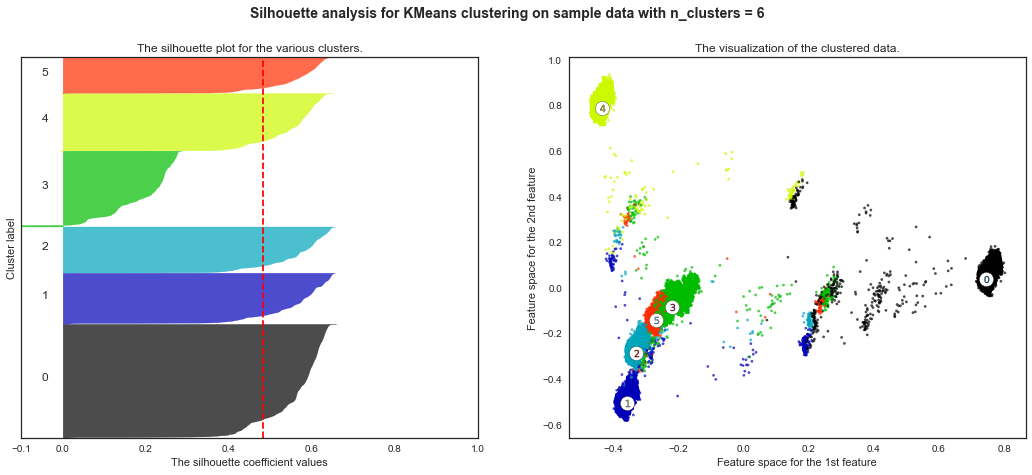

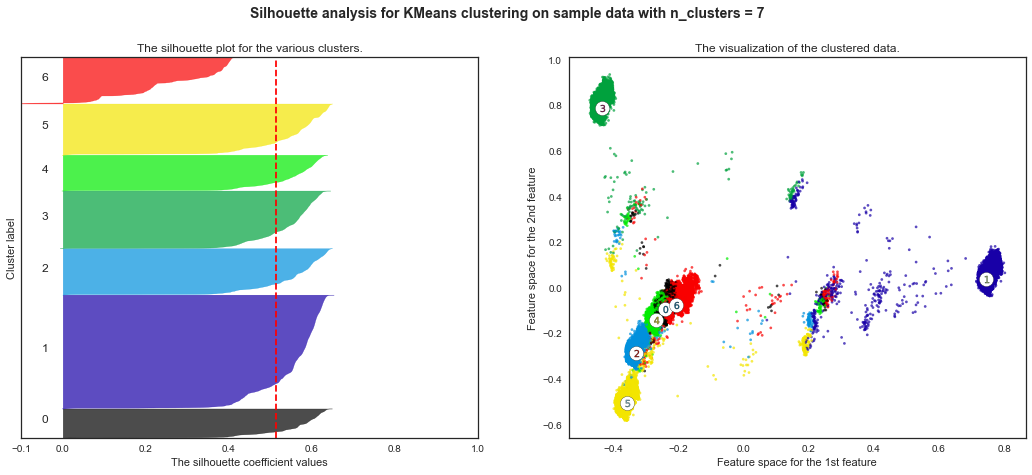

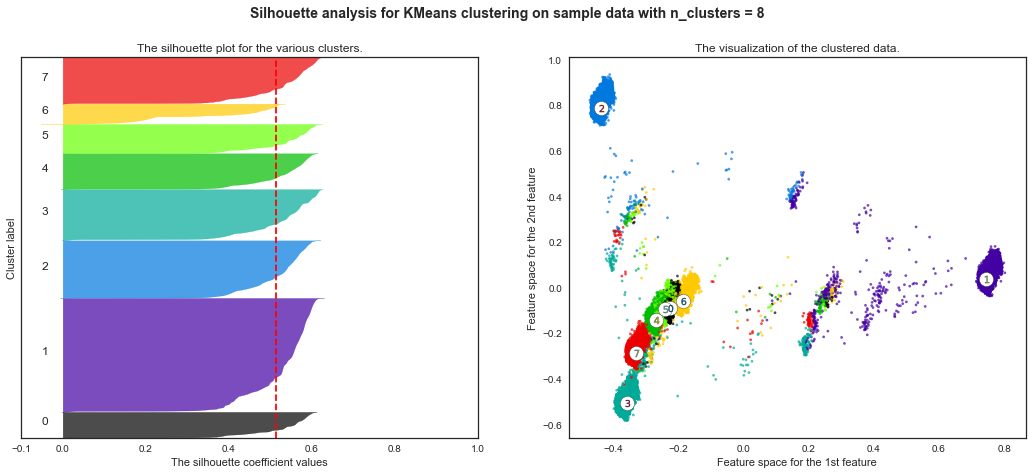

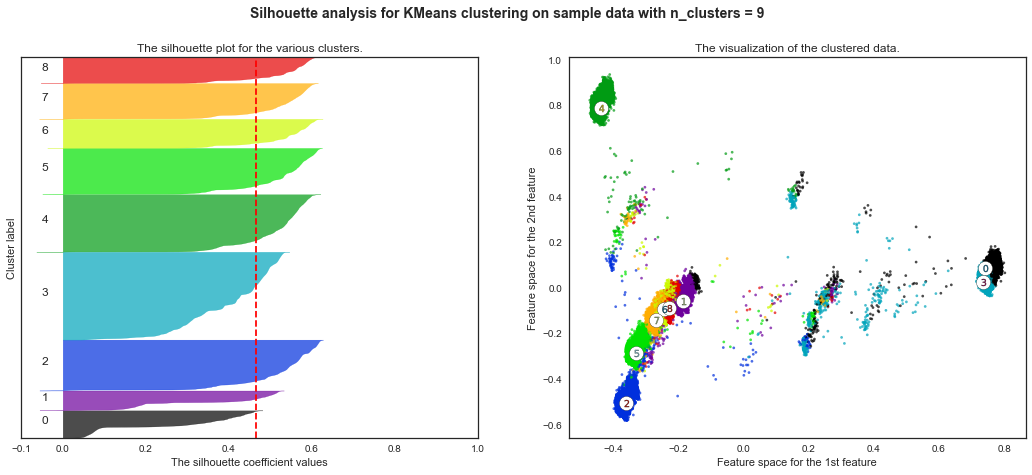

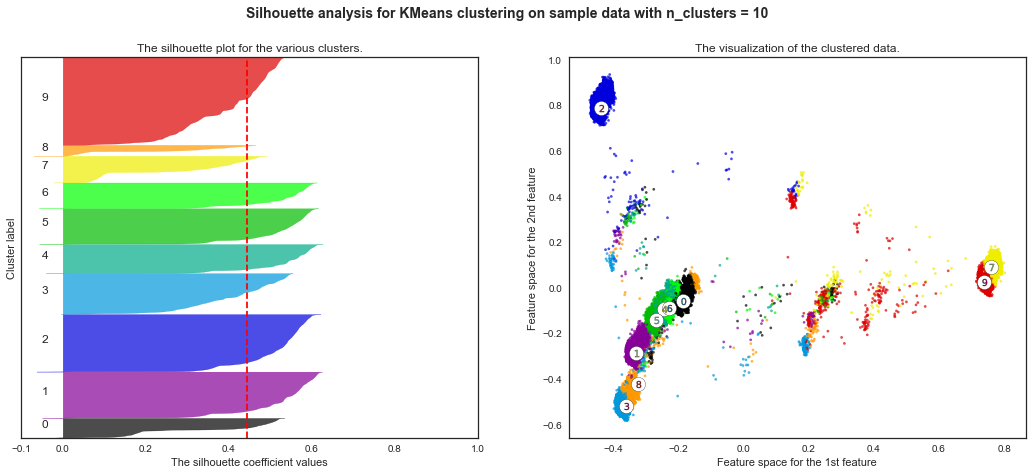

In [20]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

pf.plotSilhouetteVisualizer(pca_results, range_n_clusters)

**La méthode du coefficient moyen de Silhouette confirme que le nombre de clusters optimal se situe bien à 7 avec un score de silhouette = 0.5136388528209671**

In [21]:
N_CLUSTERS = 7

#### 3.1.2 Recap performance K-means 

In [22]:
kmeans_model = KMeans(n_clusters=N_CLUSTERS, init='k-means++', random_state=0)
algo = {"K-Means": kmeans_model}

scores = pf.getScores(algo, df_pca)
scores

Algorithme  silhouette Nb Clusters      Time
0    K-Means    0.513339           7  1.516018

#### 3.1.3 Exploration des paramètres de Kmeans

Voyons maintenant s'il est possible d'améliorer nos scores en optimisant les paramètres du KMeans via une GridSearchCV.

In [23]:
from sklearn.model_selection import GridSearchCV

parameters = [{'n_clusters': [N_CLUSTERS],
               'n_init':[5, 10, 15, 20],
               'max_iter':[100, 300, 500],
               'tol':[0.0001, 0.0003, 0.0005],
               'random_state':[42]
               }]

clf = GridSearchCV(KMeans(), parameters)

clf.fit(df_pca)

GridSearchCV(estimator=KMeans(),
             param_grid=[{'max_iter': [100, 300, 500], 'n_clusters': [7],
                          'n_init': [5, 10, 15, 20], 'random_state': [42],
                          'tol': [0.0001, 0.0003, 0.0005]}])

In [24]:
CV_optimized_model = KMeans(n_clusters=N_CLUSTERS, n_init=clf.best_params_["n_init"],
                            max_iter=clf.best_params_["max_iter"],
                            tol=clf.best_params_["tol"],
                            random_state=42)

In [25]:
algo = {"K-Means_CV": CV_optimized_model}

scores = pf.getScores(algo, df_pca)
scores

Algorithme  silhouette Nb Clusters      Time
0  K-Means_CV    0.513339           7  2.086654

Le score de silhouette n'est pas amélioré avec les paramètres de la GridSearch.

### 3.2 DBScan

#### 3.2.1 Clustering et visualisation (TSNE (14D > 2D) vs PCA 2D)   

In [26]:
#On fixe le nombre minimum de points dans un cluster comme 
# étant égal au nombre de features fois 2 
min_samples = df_pca.shape[1]*2

dbs_model = DBSCAN(eps = 0.1, min_samples = min_samples)
algo = {"DBSCAN": dbs_model}

scores = pf.getScores(algo, df_pca)
scores

Algorithme  silhouette Nb Clusters      Time
0     DBSCAN    0.052683         133  24.05119

**Observation**

DBSCAN se casse complètement la figure pour le clustering des données. Il segmente les données en plus de 130 clusters et donne un très mauvais score de silhouette. Ceci peut être justifié par la forme observée des données (présence de grappes) et le principe de fonctionnement de DBSCAN qui est plus adapté pour le clustering des données ayant d'autres types de formes.

#### 3.2.2  Exploration des paramètres de DBSCAN

Essayons de voir si on peu améliorer le score de silhouette en testant plusieurs valeurs du paramètre **eps**.

In [27]:
range_eps = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
for i in range_eps:
    print("eps value is "+ str(i))
    db = DBSCAN(eps = i, min_samples = min_samples).fit(df_pca)
    core_samples_mask = np.zeros_like(db.labels_, dtype = bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    silhouette_Avg = silhouette_score(df_pca, labels)
    print("For eps value = " + str(i) , "The avearge silhouette_score is :", silhouette_Avg)
    

eps value is 0.1
For eps value = 0.1 The avearge silhouette_score is : 0.05268325575854354
eps value is 0.2
For eps value = 0.2 The avearge silhouette_score is : 0.13150462632758542
eps value is 0.3
For eps value = 0.3 The avearge silhouette_score is : 0.0415826174770964
eps value is 0.4
For eps value = 0.4 The avearge silhouette_score is : -0.23002276612557243
eps value is 0.5
For eps value = 0.5 The avearge silhouette_score is : -0.006510871438797578
eps value is 0.6
For eps value = 0.6 The avearge silhouette_score is : 0.044396174428197405


**Observation**

Avec **eps=0.2** on arrive à améliorer le score de silhouette. Cependant, sa valeur reste très basse par rapport à celle obtenue avec K-Means

### 3.3 Clustering hierarchique 

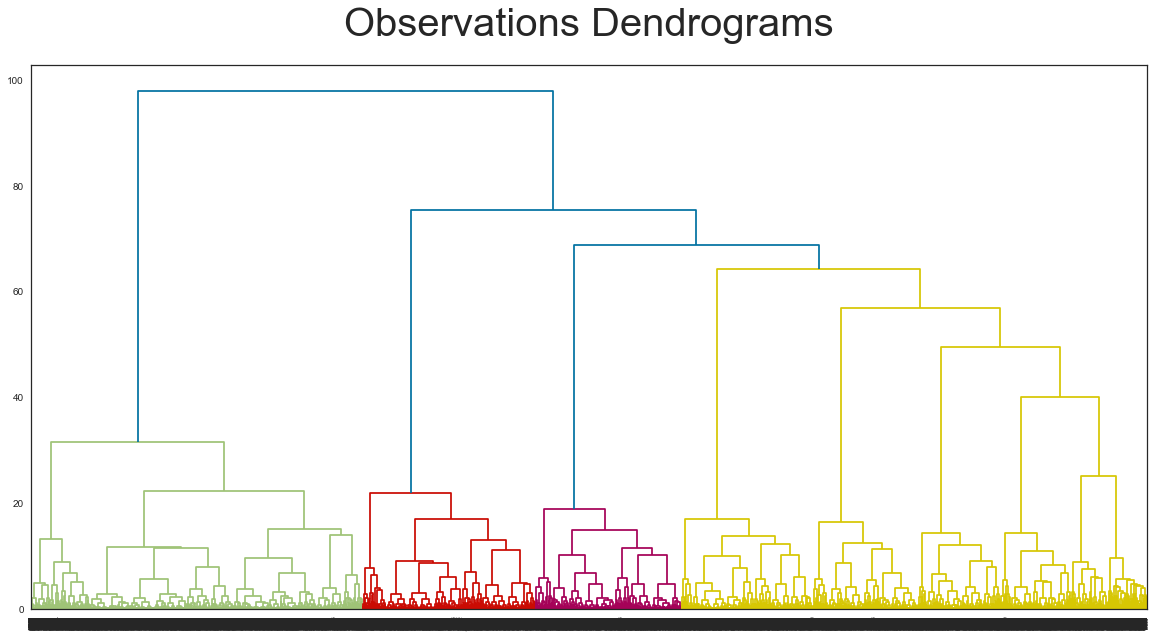

In [28]:
data_subset = df_pca.sample(n = 20000)
plt.figure(figsize = (20, 10))  
plt.title("Observations Dendrograms", fontsize=40, pad=30)  
dend = shc.dendrogram(shc.linkage(data_subset, method='ward'))

L'observation du dendrogramme suggère un regroupemant possible des données en 7 clusters

In [29]:
hierarchy_model = AgglomerativeClustering(n_clusters=N_CLUSTERS, affinity='euclidean', linkage='ward')
algo = {"Hierarchical": hierarchy_model}

scores = pf.getScores(algo, data_subset)
scores

Algorithme  silhouette Nb Clusters       Time
0  Hierarchical    0.503076           7  46.283445

**Observation**

Les performances du clustering hierarchique semblent être proches de celles de K-Means. Seulement, l'exécution de l'algorithme demande beaucoup de mémoire et prend beaucoup plus de temps (raison pour laquelle nous avons fait le test seulement sur un échantillon réduit des données).

### 3.4 Conclusion: choix du model final

L'algorithme le plus rapide, créant les clusters les plus nets et possédant le meilleur coefficient de silhouette est celui du K-means.

> **L'algorithme de Kmeans donne les meilleurs résultats. C'est ce model que nous validons pour la segmentation de nos données**

## 4.CLUSTERING AVEC K-MEANS ET CARACTERISATION DES CLUSTERS OBTENUS

### 4.1 Clustering avec l'algorithme du K-Means (sans PCA)

A présent, nous allons entrainer notre KMeans (sur les données non réduites avec PCA) avec le K optimal sélectionné et affecter son cluster à chaque lient. Ainsi, nous pourrons analyser les différences entre chaque cluster 

In [30]:
X = data.copy()

scaler = MinMaxScaler()
preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features.columns)])

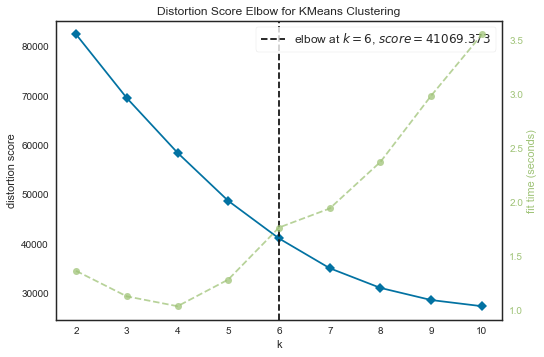

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [31]:
#Return the best number of cluster

# Elbow method
kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()


6

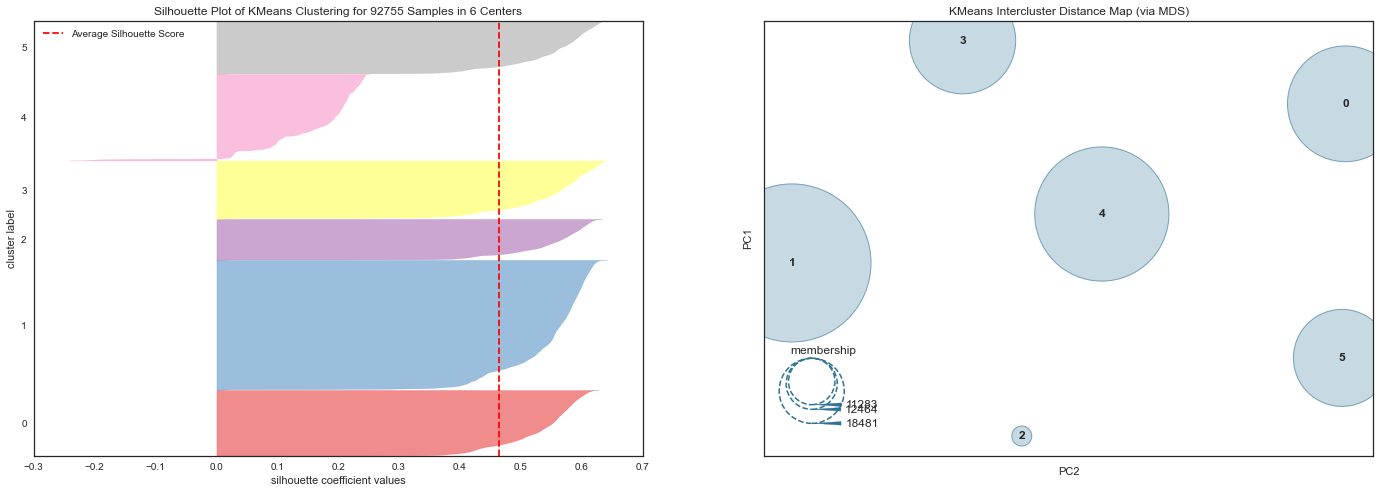

In [32]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
pf.clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X, 
                metric="distortion",
                elbow=False,
                mds=True,
                sil=True,   
                KBest=K)

**Observations**

- la méthode du coude suggère la segmentation des données en 6 clusters
- le visualiseur de silhouette montre que les clusters semblent relativement bien répartis et les séparations sont claires avec cependant quelques erreurs sur l'un des clusters.
- la projection en 2D, montre que les différents clusters sont bien séparés sur les 2 premières composantes principales. 

In [33]:
# KMeans Pipeline with best K
kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
data["kmeans_label"] = kmeans_labels

Nous allons dans un premier temps grouper les individus par cluster pour analyser les moyennes :

In [34]:
kmeans_clusters_means = data.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

kmeans_label  nb_orders  total_spend  mean_payment_sequential  \
0             0   1.041660   147.028725                 1.040316   
1             1   1.021368   145.130223                 1.036491   
2             2   1.040924   163.683648                 1.055469   
3             3   1.029430   163.452749                 1.034298   
4             4   1.030079   178.308791                 1.041650   
5             5   1.022693   221.410386                 1.041872   

   mean_payment_installments  mean_review_score  mean_delivery_days  \
0                   2.673778           4.237117           11.863277   
1                   2.255461           4.090689           13.059866   
2                   3.286992           4.076953           12.932771   
3                   3.145237           4.244072           12.001861   
4                   2.837773           4.178393           12.100258   
5                   3.637061           4.166575           12.616450   

   favorite_sale_month  books_cds_media  fashion_clothing_accessories  ...  \
0             6.257426         0.045086                      0.168169  ...   
1             5.698575         0.000036                      0.000679  ...   
2             6.046219         0.000138                      0.000706  ...   
3             6.069852         0.000177                      0.000591  ...   
4             5.861555         0.000201                      0.001183  ...   
5             6.268883         0.000115                      0.000802  ...   

   health_beauty  home_furniture     other     sport  technology  toys_baby  \
0       0.001733        0.004059  0.002002  0.386359    0.001486   0.341375   
1       0.000350        0.001654  0.000379  0.000018    0.996134   0.000095   
2       0.000640        0.993884  0.001476  0.000195    0.001424   0.000567   
3       0.993399        0.002637  0.000545  0.000099    0.001197   0.000126   
4       0.001772        0.005174  0.987388  0.000128    0.002088   0.000655   
5       0.000764        0.002541  0.000730  0.000061    0.001757   0.000481   

   total_items  order_mean_delay  freight_ratio  harvesine_distance  
0     1.149381        242.323002       0.203615          430.748075  
1     1.153134        236.379006       0.260095          471.927214  
2     1.276307        236.698318       0.216081          399.253022  
3     1.126673        222.067513       0.188682          464.060583  
4     1.152242        210.968143       0.204044          433.717987  
5     1.086304        234.532388       0.140134          484.475298  

[6 rows x 22 columns]

In [35]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 92755 samples in 0.010s...
[t-SNE] Computed neighbors for 92755 samples in 238.283s...
[t-SNE] Computed conditional probabilities for sample 1000 / 92755
[t-SNE] Computed conditional probabilities for sample 2000 / 92755
[t-SNE] Computed conditional probabilities for sample 3000 / 92755
[t-SNE] Computed conditional probabilities for sample 4000 / 92755
[t-SNE] Computed conditional probabilities for sample 5000 / 92755
[t-SNE] Computed conditional probabilities for sample 6000 / 92755
[t-SNE] Computed conditional probabilities for sample 7000 / 92755
[t-SNE] Computed conditional probabilities for sample 8000 / 92755
[t-SNE] Computed conditional probabilities for sample 9000 / 92755
[t-SNE] Computed conditional probabilities for sample 10000 / 92755
[t-SNE] Computed conditional probabilities for sample 11000 / 92755
[t-SNE] Computed conditional probabilities for sample 12000 / 92755
[t-SNE] Computed conditional probabilities for 

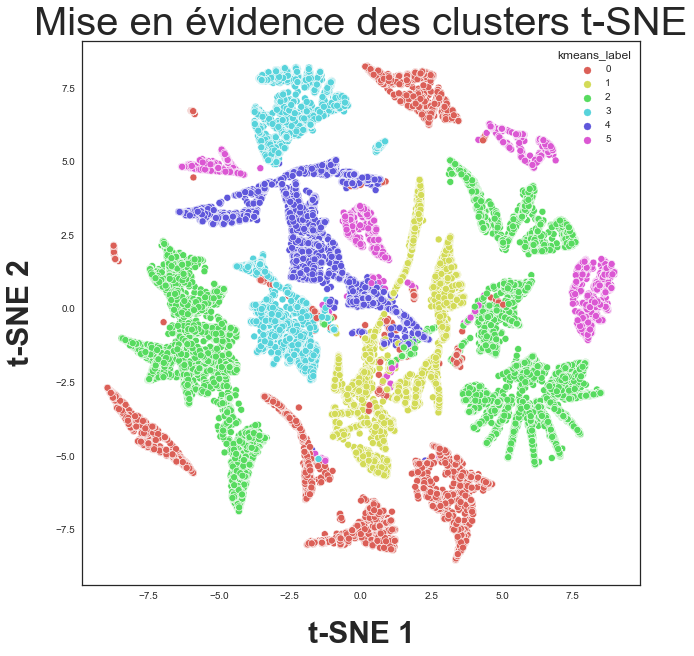

In [36]:
pf.plotTSNE(X_scaled, kmeans_labels)

**Nombre de clients par cluster**

In [38]:
X_scaled["kmeans_label"] = kmeans_labels
X_scaled.groupby("kmeans_label").size().reset_index(name='counts')

kmeans_label  counts
0             0   18483
1             1   14040
2             2   27759
3             3   11281
4             4   12467
5             5    8725

In [39]:
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

nb_orders  total_spend  mean_payment_sequential  \
kmeans_label                                                    
0              0.002976     0.010065                 0.001613   
1              0.001526     0.009926                 0.001460   
2              0.002923     0.011285                 0.002219   
3              0.002102     0.011268                 0.001372   
4              0.002149     0.012356                 0.001666   
5              0.001621     0.015513                 0.001675   

              mean_payment_installments  mean_review_score  \
kmeans_label                                                 
0                              0.102838           0.809279   
1                              0.086748           0.772672   
2                              0.126423           0.769238   
3                              0.120971           0.811018   
4                              0.109145           0.794598   
5                              0.139887           0.791644   

              mean_delivery_days  favorite_sale_month  books_cds_media  \
kmeans_label                                                             
0                       0.052480             0.477948         0.045086   
1                       0.058260             0.427143         0.000036   
2                       0.057646             0.458747         0.000138   
3                       0.053149             0.460896         0.000177   
4                       0.053624             0.441960         0.000201   
5                       0.056118             0.478989         0.000115   

              fashion_clothing_accessories  flowers_gifts  ...  health_beauty  \
kmeans_label                                               ...                  
0                                 0.168169       0.001865  ...       0.001733   
1                                 0.000679       0.000430  ...       0.000350   
2                                 0.000706       0.000810  ...       0.000640   
3                                 0.000591       0.000621  ...       0.993399   
4                                 0.001183       0.001295  ...       0.001772   
5                                 0.000802       0.992726  ...       0.000764   

              home_furniture     other     sport  technology  toys_baby  \
kmeans_label                                                              
0                   0.004059  0.002002  0.386359    0.001486   0.341375   
1                   0.001654  0.000379  0.000018    0.996134   0.000095   
2                   0.993884  0.001476  0.000195    0.001424   0.000567   
3                   0.002637  0.000545  0.000099    0.001197   0.000126   
4                   0.005174  0.987388  0.000128    0.002088   0.000655   
5                   0.002541  0.000730  0.000061    0.001757   0.000481   

              total_items  order_mean_delay  freight_ratio  harvesine_distance  
kmeans_label                                                                    
0                0.006495          0.339864       0.212099            0.162823  
1                0.006658          0.331527       0.270932            0.183633  
2                0.012013          0.331975       0.225085            0.146906  
3                0.005508          0.311455       0.196544            0.179658  
4                0.006619          0.295888       0.212546            0.164324  
5                0.003752          0.328937       0.145973            0.189974  

[6 rows x 21 columns]

Projetons à présent ces différentes moyennes sur un Radar plot avec la librairie Ploty pour visualiser les différences entre cluster :

In [40]:
pf.plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

Malheureusement ici, la segmentation se base principalement sur les catégories de produit achetées. **Le poids de ces features masque les autres axes de catégorisation**, nous allons donc réaliser un nouveau K-Means en supprimant ces variables 

### Clustering sans les catégories produits

In [41]:
categories_col = ['books_cds_media',
                  'fashion_clothing_accessories',
                  'flowers_gifts',
                  'groceries_food_drink',
                  'health_beauty',
                  'home_furniture',
                  'other',
                  'sport',
                  'technology',
                  'toys_baby']
X_bis = X.drop(categories_col, axis=1)
X_bis.head(3)

nb_orders  total_spend  \
customer_unique_id                                         
0000366f3b9a7992bf8c76cfdf3221e2          1       141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f          1        27.19   
0000f46a3911fa3c0805444483337064          1        86.22   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2                      1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                      1.0   
0000f46a3911fa3c0805444483337064                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2                        8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        1.0   
0000f46a3911fa3c0805444483337064                        8.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000366f3b9a7992bf8c76cfdf3221e2                5.0                 6.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                4.0                 3.0   
0000f46a3911fa3c0805444483337064                3.0                26.0   

                                  favorite_sale_month  total_items  \
customer_unique_id                                                   
0000366f3b9a7992bf8c76cfdf3221e2                    5          1.0   
0000b849f77a49e4a4ce2b2a4ca5be3f                    5          1.0   
0000f46a3911fa3c0805444483337064                    3          1.0   

                                  order_mean_delay  freight_ratio  \
customer_unique_id                                                  
0000366f3b9a7992bf8c76cfdf3221e2             111.0           0.08   
0000b849f77a49e4a4ce2b2a4ca5be3f             114.0           0.30   
0000f46a3911fa3c0805444483337064             537.0           0.20   

                                  harvesine_distance  
customer_unique_id                                    
0000366f3b9a7992bf8c76cfdf3221e2          209.713834  
0000b849f77a49e4a4ce2b2a4ca5be3f          209.713834  
0000f46a3911fa3c0805444483337064          125.363853

In [42]:
preprocessor = ColumnTransformer([
    ('scaler', scaler, X_bis.columns)])

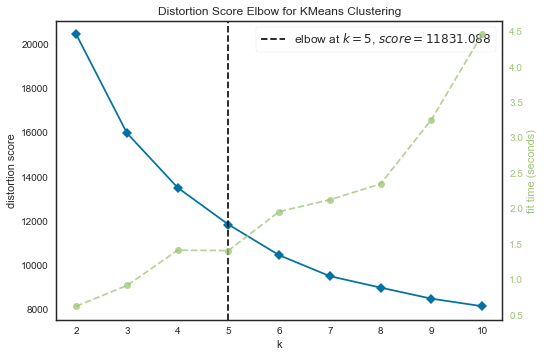

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
#Return the best number of cluster

kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(4,12)))])
kmeans_visualizer.fit(X_bis)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()



5

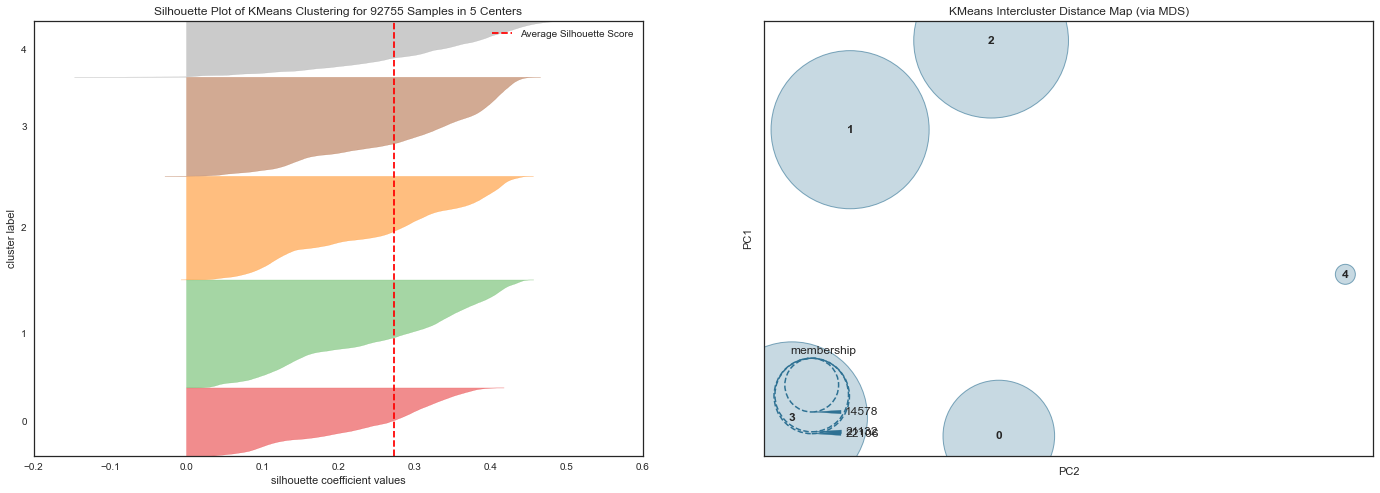

In [44]:
# Best K in Elbow
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
pf.clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_bis, 
                metric="distortion",
                elbow=False,
                mds=True,
                sil=True,   
                KBest=K)

In [45]:
# KMeans Pipeline with best K
kmeans_model_bis = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_bis.fit(X_bis)

# Kmeans labels
kmeans_labels_bis = kmeans_model_bis.named_steps['kmeans'].labels_

# Scale X
scaler = MinMaxScaler()
X_scaled_bis = scaler.fit_transform(X_bis)
X_scaled_bis = pd.DataFrame(X_scaled_bis, index=X_bis.index, columns=X_bis.columns)


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 92755 samples in 0.498s...
[t-SNE] Computed neighbors for 92755 samples in 78.230s...
[t-SNE] Computed conditional probabilities for sample 1000 / 92755
[t-SNE] Computed conditional probabilities for sample 2000 / 92755
[t-SNE] Computed conditional probabilities for sample 3000 / 92755
[t-SNE] Computed conditional probabilities for sample 4000 / 92755
[t-SNE] Computed conditional probabilities for sample 5000 / 92755
[t-SNE] Computed conditional probabilities for sample 6000 / 92755
[t-SNE] Computed conditional probabilities for sample 7000 / 92755
[t-SNE] Computed conditional probabilities for sample 8000 / 92755
[t-SNE] Computed conditional probabilities for sample 9000 / 92755
[t-SNE] Computed conditional probabilities for sample 10000 / 92755
[t-SNE] Computed conditional probabilities for sample 11000 / 92755
[t-SNE] Computed conditional probabilities for sample 12000 / 92755
[t-SNE] Computed conditional probabilities for s

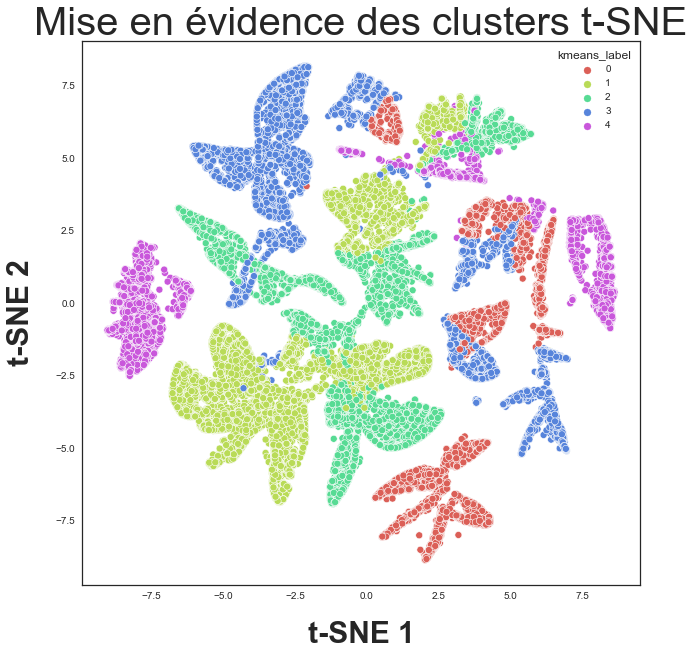

In [46]:
pf.plotTSNE(X_scaled_bis, kmeans_labels_bis)

In [47]:
X_scaled_bis["kmeans_label"] = kmeans_labels_bis

# Group by cluster
X_scaled_clusters_bis = X_scaled_bis.groupby("kmeans_label").mean()

# Plot Radar chart
pf.plot_radars(data=X_scaled_clusters_bis,
            group="kmeans_label")

**Nombre de clients par cluster**

In [48]:
X_scaled_bis.groupby("kmeans_label").size().reset_index(name='counts')

kmeans_label  counts
0             0   14578
1             1   23035
2             2   22106
3             3   21132
4             4   11904

### Interprétation métier des clusters


- **Cluster 2** : 
    * Proches géographiquement du siège d'Olist avec de courts délais de livraison
    * Commandent principalement en début d'année pour des montants faibles 
    * Paient avec 1 type de moyen de paiement et avec un nombre faible d'échéances
    * Très satisfaits

- **Cluster 1** : 
    * Ont passés un nombre important de commandes
    * Proches géographiquement du siège d'Olist avec de courts délais de livraison
    * Paient comptant pour un montant moyen de commande
    * Très satisfaits

- **Cluster 4** : 
    * Eloignés géographiquement du siège d'Olist avec de frais et délais de livraison élevés
    * Ont dépensés le plus et commandé un grand nombre d'articles et passés un nombre de commande moyen
    * Paient en plusieurs échéances avec plusieurs moyens de paiement
    * Très insatisfaits
    
- **Cluster 3** :     
    * Clients de fin d'année
    * Géographiquement peu éloignés avec des délais de livraison moyens
    * Paient en plusieurs échéances avec plusieurs moyens de paiement pour des montants faibles
    * Très satisfaits
  
- **Cluster 0** :     
    * Utilisent plusieurs moyens de paiement et un nombre important d'échéances
    * Pas très éloignés du siège d'Olist
    * Ont tendance à espacer les délais entre 2 commandes
    * Ont très peu commandé et donc très peu dépensés
    * Très satisfaits


### 4.2 Clustering avec l'algorithme du K-Means (avec PCA)

Nous allons appliquer l'algorithme k-means sur nos données réduites avec PCA pour vérifier si la réduction dimensionnelle réduit la qualité de la segmentation

In [49]:
# PCA Pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X_bis)
X_projected = pca.transform(X_bis)

### Eboulis des valeurs propres

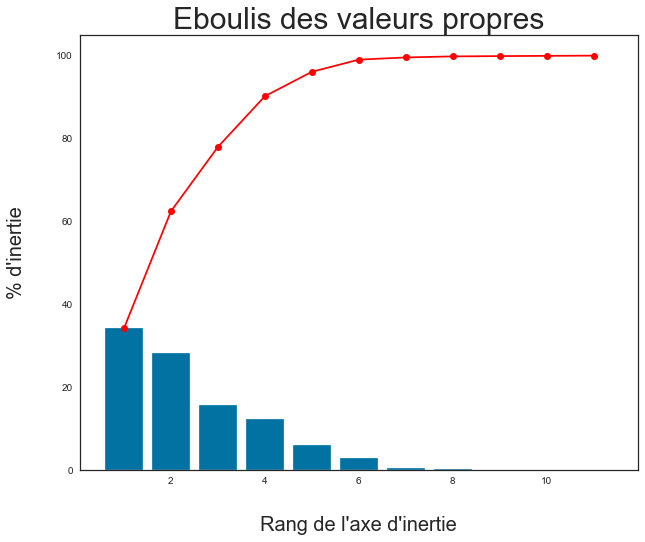

In [50]:
pf.display_scree_plot(pca['pca'])

Il faut conserver 5 compasantes principale pour expliquer la variance à 95%.

5

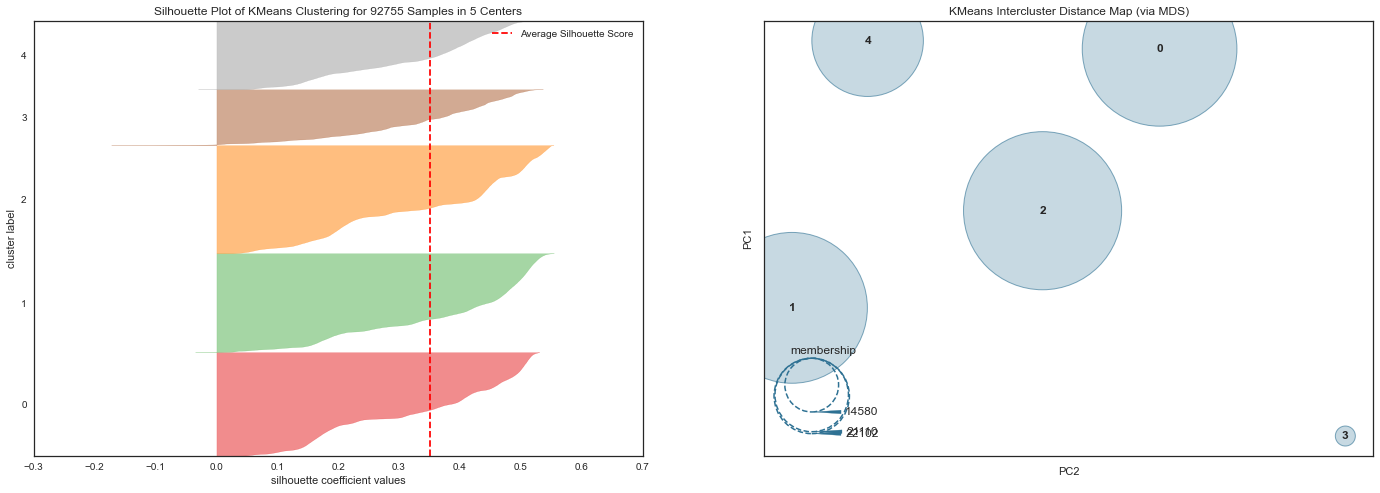

In [51]:
pf.clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:4], 
                metric="distortion",
                elbow=False,
                mds=True,
                sil=True,   
                KBest=K)

In [52]:
# KMeans Pipeline with best K for PCA results
kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),
                             ("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:4])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled_bis["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled_bis.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

nb_orders  total_spend  mean_payment_sequential  \
kmeans_label_pca                                                    
0                  0.001076     0.010855                 0.001729   
1                  0.001878     0.013437                 0.001880   
2                  0.005084     0.011718                 0.001477   
3                  0.002705     0.010774                 0.001594   
4                  0.000010     0.010819                 0.002373   

                  mean_payment_installments  mean_review_score  \
kmeans_label_pca                                                 
0                                  0.116593           0.892984   
1                                  0.124029           0.064064   
2                                  0.109970           0.906153   
3                                  0.104761           0.887036   
4                                  0.122426           0.892367   

                  mean_delivery_days  favorite_sale_month  total_items  \
kmeans_label_pca                                                         
0                           0.054391             0.837222     0.005753   
1                           0.092783             0.436962     0.015212   
2                           0.038602             0.502573     0.008788   
3                           0.056389             0.136211     0.006680   
4                           0.051892             0.341561     0.004908   

                  order_mean_delay  freight_ratio  harvesine_distance  
kmeans_label_pca                                                       
0                         0.436528       0.211623            0.169806  
1                         0.324553       0.222193            0.191882  
2                         0.083445       0.219641            0.154151  
3                         0.247196       0.214373            0.156692  
4                         0.669150       0.219321            0.172279

In [53]:
pf.plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

**Observations**

- **On retrouve les mêmes axes de segmentation après réduction de dimension**. Il est donc possible de réduire le nombre de features en entrée et d'utiliser les variables synthétiques de la PCA pour segmenter nos données 
- **le score de silhouette moyen est meilleur comparé à celui obtenu avec les données brutes**.

### 4.3 Etude de la stabilité à l'initialisation du K-Means

Nous allons **tester la stabilité à l'initialisation de K-Means en entrainant plusieurs fois le modèle sans fixer le RandomState**.

Pour les labels initiaux, nous allons conserver les clusters calculés dans le dernier modèle *(avec PCA)* puis les comparer grâce à l'**indice de Rand ajusté** *(ARI)* pour chacune des itérations.

In [56]:
labels = pca_kmeans_labels
pca_data = X_projected[:,:4]
model = KMeans(n_clusters=K, n_init=1, init="k-means++")
nb_iter = 10

scores_time = pf.stabilityCheck(nb_iter, K, model, pca_data, labels)
scores_time

Iteration  silhouette       ARI      Time
0        0.0    0.341223  0.999950  0.269085
1        1.0    0.341223  0.999925  0.177918
2        2.0    0.316205  0.566571  0.201203
3        3.0    0.341223  0.999919  0.149117
4        4.0    0.336672  0.601328  0.216980
5        5.0    0.315773  0.566268  0.175997
6        6.0    0.342655  0.607031  0.178920
7        7.0    0.341223  1.000000  0.175065
8        8.0    0.342410  0.606032  0.165730
9        9.0    0.341223  0.999925  0.224489

**Observation**

Les différentes itérations montrent:
- des scores de silhouette proches
- des scores ARI proches de 1.

>Mise en évidence de la stabilité à l'initialisation de K-Means.

## 5. ETUDE DE LA FREQUENCE DE MISE A JOUR DE LA SEGMENTATION

Dans le but d'établir un contrat de maintenance de l'algorithme de segmentation client, nous devons tester sa stabilité dans le temps et **voir, par exemple, à quel moment les clients changent de Cluster**.

In [57]:
# Initial period of 12 months
data_init = pf.create_dataset(dpath="../DataSet/", initial=True, period=2)

In [58]:
# Remove categories
data_init.drop(categories_col, axis=1, inplace=True)
data_init.head(3)

nb_orders  total_items  total_spend  \
customer_unique_id                                                      
0000f46a3911fa3c0805444483337064          1            1        86.22   
0005e1862207bf6ccc02e4228effd9a0          1            1       150.12   
0006fdc98a402fceb4eb0ee528f6a8d4          1            1        29.00   

                                  mean_payment_sequential  \
customer_unique_id                                          
0000f46a3911fa3c0805444483337064                      1.0   
0005e1862207bf6ccc02e4228effd9a0                      1.0   
0006fdc98a402fceb4eb0ee528f6a8d4                      1.0   

                                  mean_payment_installments  \
customer_unique_id                                            
0000f46a3911fa3c0805444483337064                        8.0   
0005e1862207bf6ccc02e4228effd9a0                        3.0   
0006fdc98a402fceb4eb0ee528f6a8d4                        2.0   

                                  mean_review_score  mean_delivery_days  \
customer_unique_id                                                        
0000f46a3911fa3c0805444483337064                3.0                26.0   
0005e1862207bf6ccc02e4228effd9a0                4.0                 4.0   
0006fdc98a402fceb4eb0ee528f6a8d4                3.0                16.0   

                                  favorite_sale_month  order_mean_delay  \
customer_unique_id                                                        
0000f46a3911fa3c0805444483337064                    3             178.0   
0005e1862207bf6ccc02e4228effd9a0                    3             184.0   
0006fdc98a402fceb4eb0ee528f6a8d4                    7              48.0   

                                  freight_ratio  haversine_distance  
customer_unique_id                                                   
0000f46a3911fa3c0805444483337064           0.20          125.363853  
0005e1862207bf6ccc02e4228effd9a0           0.10          428.916514  
0006fdc98a402fceb4eb0ee528f6a8d4           0.52          669.215559

In [59]:
data_init.shape

(22861, 11)

Nous allons ensuite déterminer la période totale à couvrir :

In [60]:
olist_path = "../DataSet/"
orders = pd.read_csv(olist_path+"olist_orders_dataset.csv")
orders = orders.loc[orders.order_status == "delivered", 
                    "order_purchase_timestamp"]
orders = pd.to_datetime(orders)
time_delta = int((orders.max() - orders.min())/np.timedelta64(1,'M'))
print("La période complète des commandes porte sur {} mois.".format(time_delta))

La période complète des commandes porte sur 23 mois.


Pour déterminer le moment où les clients changent de cluster, nous allons **itérer le K-Means sur toute la période avec des deltas de 3 mois et calculer le score ARI**, en prenant garde à bien comparer les mêmes clients *(ceux des 12 mois initiaux)*. 


In [61]:
# Kmeans on initial period
kmeans_init = Pipeline([("preprocessor", MinMaxScaler()),
                        ("kmeans", KMeans(K, random_state=42))])
kmeans_init.fit(data_init)
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [62]:
ari_score = []
for p in np.arange(3,(time_delta-12),3):
    # Create dataset for period
    data_period = pf.create_dataset(dpath="../DataSet/", 
                                   initial=False, 
                                   period=p)
    data_period.drop(categories_col, axis=1, inplace=True)
    
    # Filter on initial customer client
    data_period = data_period[data_period.index.isin(data_init.index)]
    
    # K-Means
    kmeans_p = Pipeline([("preprocessor", MinMaxScaler()),
                         ("kmeans", KMeans(K, random_state=42))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_
    
    # Calculate ARI score
    ari_p = adjusted_rand_score(init_labels, kmeans_p[1].labels_)
    ari_score.append([p,ari_p])
    

In [63]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])
ari_score

periode       ARI
0        3  0.960803
1        6  0.762966
2        9  0.579155

**Observation**

Après ajout de 6 mois de données sur les 12 mois de données initiales, on constate une dégradation plus ou moins importante du score ARI.

**Conclusion**

Il faudra donc **prévoir la maintenance du programme de segmentation tous les 6 mois** dans un premier temps puis re-tester cette stabilité temporelle au fil du temps afin de l'affiner. Il sera donc nécessaire de redéfinir les segments clients à chaque maintenance.